In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark as ps    # for the pyspark suite
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import IntegerType, StringType, FloatType, DateType, TimestampType
import pyspark.sql.functions as F

spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("df lecture") \
            .getOrCreate()

sc = spark.sparkContext  # for the pre-2.0 sparkContext

# 1. Importing Data

## 1.1. Users dataframe

First, load `data/users.dat` into an RDD for cleaning.

In [2]:
users_raw = sc.textFile("../data/users.dat")

print(users_raw.take(5))

[u'1::F::1::10::48067', u'2::M::56::16::70072', u'3::M::25::15::55117', u'4::M::45::7::02460', u'5::M::25::20::55455']


Then we "clean" that rdd by splitting values, casting types and translating numerical ids into categorical (explicit strings) values.

In [3]:
def users_cleaning_functions(row_string):
    fields_ = row_string.split("::")
    user_id, gender_str, age_id, occupation_id, zipcode = fields_

    user_id = int(user_id)
    
    gender_dict = {'F':1, 'M':0}
    gender_id = gender_dict[gender_str]

    age_dict = {1:"Under 18",
                18:  "18-24",
                25:  "25-34",
                35:  "35-44",
                45:  "45-49",
                50:  "50-55",
                56:  "56+"}
    age = age_dict[int(age_id)]
    
    occupation_dict = {0:  "other",
                1:  "academic/educator",
                2:  "artist",
                3:  "clerical/admin",
                4:  "college/grad student",
                5:  "customer service",
                6:  "doctor/health care",
                7:  "executive/managerial",
                8:  "farmer",
                9:  "homemaker",
                10:  "K-12 student",
                11:  "lawyer",
                12:  "programmer",
                13:  "retired",
                14:  "sales/marketing",
                15:  "scientist",
                16:  "self-employed",
                17:  "technician/engineer",
                18:  "tradesman/craftsman",
                19:  "unemployed",
                20:  "writer" }
    occupation = occupation_dict[int(occupation_id)]
    
    return((user_id,
            gender_id,
            gender_str,
            int(age_id),
            age,
            int(occupation_id),
            occupation, zipcode))

users_clean = users_raw.map(users_cleaning_functions)

print(users_clean.take(5))

[(1, 1, u'F', 1, 'Under 18', 10, 'K-12 student', u'48067'), (2, 0, u'M', 56, '56+', 16, 'self-employed', u'70072'), (3, 0, u'M', 25, '25-34', 15, 'scientist', u'55117'), (4, 0, u'M', 45, '45-49', 7, 'executive/managerial', u'02460'), (5, 0, u'M', 25, '25-34', 20, 'writer', u'55455')]


Create a DataFrame by providing the right schema.

In [4]:
users_schema = StructType( [
    StructField('user',IntegerType(),True),
    StructField('gender_id',IntegerType(),True),
    StructField('gender',StringType(),True),
    StructField('age_id',IntegerType(),True),
    StructField('age',StringType(),True),
    StructField('occupation_id',IntegerType(),True),
    StructField('occupation',StringType(),True),
    StructField('zipcode',StringType(),True) ] )

users = spark.createDataFrame(users_clean, users_schema)

users.show(5)
users.printSchema()

+----+---------+------+------+--------+-------------+--------------------+-------+
|user|gender_id|gender|age_id|     age|occupation_id|          occupation|zipcode|
+----+---------+------+------+--------+-------------+--------------------+-------+
|   1|        1|     F|     1|Under 18|           10|        K-12 student|  48067|
|   2|        0|     M|    56|     56+|           16|       self-employed|  70072|
|   3|        0|     M|    25|   25-34|           15|           scientist|  55117|
|   4|        0|     M|    45|   45-49|            7|executive/managerial|  02460|
|   5|        0|     M|    25|   25-34|           20|              writer|  55455|
+----+---------+------+------+--------+-------------+--------------------+-------+
only showing top 5 rows

root
 |-- user: integer (nullable = true)
 |-- gender_id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age_id: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- occupation_id: integer (nul

## 1.2. Movies dataframe

Load the `data/movies.dat` file in an RDD.

In [5]:
movies_raw = sc.textFile("../data/movies.dat")

print(movies_raw.take(5))

[u"1::Toy Story (1995)::Animation|Children's|Comedy", u"2::Jumanji (1995)::Adventure|Children's|Fantasy", u'3::Grumpier Old Men (1995)::Comedy|Romance', u'4::Waiting to Exhale (1995)::Comedy|Drama', u'5::Father of the Bride Part II (1995)::Comedy']


The "genres" column is formatted as a `|` separated-list. Our choice here is to 'pivot' the movies genres so that we assign one column per genre, and have a value (`1` or `null`) indicating if the movie belongs to this genre. This will let us query this dataset by genre more easily and create a genre vector.

**First step** to achieve that, create one line per `movie * genre`. Here, `split()` on genres then `flatMap()`.

In [6]:
def movies_cleaning_function(inputstring):
    """ to be used inside flatMap, returns a list """
    movie_id_, title_, genres_ = inputstring.split("::")
    movie_id_ = int(movie_id_)
    year_ = re.search('.*\(([0-9]+)\)$', title_).group(1)
    return [(movie_id_, title_, int(year_), token) for token in genres_.split('|')]

movies_clean = movies_raw.flatMap(movies_cleaning_function)

print(movies_clean.take(5))

[(1, u'Toy Story (1995)', 1995, u'Animation'), (1, u'Toy Story (1995)', 1995, u"Children's"), (1, u'Toy Story (1995)', 1995, u'Comedy'), (2, u'Jumanji (1995)', 1995, u'Adventure'), (2, u'Jumanji (1995)', 1995, u"Children's")]


Then we turn it into a dataframe and use the `pivot()` function to do the trick.

In [7]:
movies_schema = StructType( [
    StructField('movie',IntegerType(),True),
    StructField('title',StringType(),True),
    StructField('year',IntegerType(),True),
    StructField('genre',StringType(),True) ] )

movies = spark.createDataFrame(movies_clean, movies_schema)

# pivot movie genres
movies = movies.groupBy("movie", "title", "year")\
               .pivot("genre")\
               .agg(F.count(F.col('genre')))\
               .na.fill(0)

movies.show(5)
movies.printSchema()

+-----+--------------------+----+------+---------+---------+----------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+---+-------+
|movie|               title|year|Action|Adventure|Animation|Children's|Comedy|Crime|Documentary|Drama|Fantasy|Film-Noir|Horror|Musical|Mystery|Romance|Sci-Fi|Thriller|War|Western|
+-----+--------------------+----+------+---------+---------+----------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+---+-------+
|  380|    True Lies (1994)|1994|     1|        1|        0|         0|     1|    0|          0|    0|      0|        0|     0|      0|      0|      1|     0|       0|  0|      0|
| 3341|Born Yesterday (1...|1950|     0|        0|        0|         0|     1|    0|          0|    0|      0|        0|     0|      0|      0|      0|     0|       0|  0|      0|
| 3699|      Starman (1984)|1984|     0|        1|        0|         0|     0|    0|          0|    

## 1.3. Reading Training set (ratings)

`data/training.csv` is already formatted as a CSV file, we just enforce our own schema on it with the column names we choose.

In [8]:
ratings_schema = StructType( [
    StructField('user',IntegerType(),True),
    StructField('movie',IntegerType(),True),
    StructField('rating',FloatType(),True),
    StructField('timestamp',IntegerType(),True) ] )

# read CSV
ratings = spark.read.csv('../data/training.csv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep=",",           # char for separation
                         inferSchema=False,
                         schema=ratings_schema)

ratings.show(5)
ratings.printSchema()
print("ratings has {} rows".format(ratings.count()))

+----+-----+------+---------+
|user|movie|rating|timestamp|
+----+-----+------+---------+
|6040|  858|   4.0|956703932|
|6040|  593|   5.0|956703954|
|6040| 2384|   4.0|956703954|
|6040| 1961|   4.0|956703977|
|6040| 2019|   5.0|956703977|
+----+-----+------+---------+
only showing top 5 rows

root
 |-- user: integer (nullable = true)
 |-- movie: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: integer (nullable = true)

ratings has 800000 rows


## 1.4. Reading requests

In [9]:
request_schema = StructType( [
    StructField('user',IntegerType(),True),
    StructField('movie',IntegerType(),True) ] )

# read CSV
requests = spark.read.csv('../data/requests.csv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep=",",           # char for separation
                         inferSchema=False,
                         schema=request_schema)

requests.show(5)
requests.printSchema()
print("requests has {} rows".format(requests.count()))

+----+-----+
|user|movie|
+----+-----+
|4958| 1924|
|4958| 3264|
|4958| 2634|
|4958| 1407|
|4958| 2399|
+----+-----+
only showing top 5 rows

root
 |-- user: integer (nullable = true)
 |-- movie: integer (nullable = true)

requests has 200209 rows


# 2. EDA

## 2.1. Example Queries

### How many users and movies are there ?

In [10]:
print("user count: {}".format(users.select('user').distinct().count()))
print("movie count: {}".format(movies.select('movie').distinct().count()))

user count: 6040
movie count: 3883


### How many ratings for each movie ?

In [11]:
rating_count = ratings.groupBy("movie").count().rdd.values().histogram(20)

In [12]:
rating_count[0].pop(0)

print(len(rating_count[0]))
print(len(rating_count[1]))

20
20


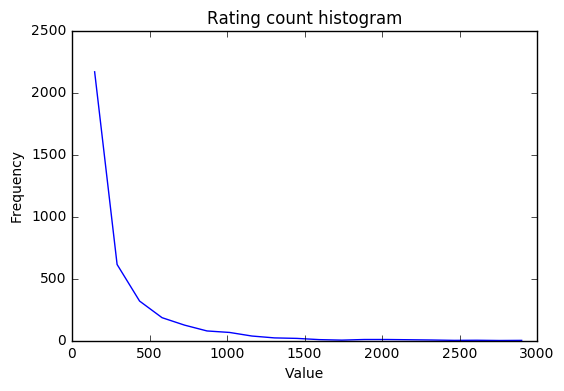

In [13]:
plt.plot(rating_count[0], rating_count[1])
plt.title("Rating count histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

### What are the 20 most popular movies by rating count ?

In [14]:
best_movies = ratings.groupBy("movie").count()\
              .orderBy('count', ascending=False).limit(20)\
              .join(movies, 'movie')\
              .select("movie", "title", "year", "count").show()

+-----+--------------------+----+-----+
|movie|               title|year|count|
+-----+--------------------+----+-----+
| 1196|Star Wars: Episod...|1980| 2516|
| 1097|E.T. the Extra-Te...|1982| 1910|
|  589|Terminator 2: Jud...|1991| 2284|
|  260|Star Wars: Episod...|1977| 2515|
| 1617|L.A. Confidential...|1997| 1929|
|  110|   Braveheart (1995)|1995| 2081|
|  593|Silence of the La...|1991| 2151|
| 2571|  Matrix, The (1999)|1999| 2172|
| 1210|Star Wars: Episod...|1983| 2456|
| 1198|Raiders of the Lo...|1981| 2110|
| 1580| Men in Black (1997)|1997| 2156|
|  608|        Fargo (1996)|1996| 2144|
| 2762|Sixth Sense, The ...|1999| 2024|
| 2396|Shakespeare in Lo...|1998| 1995|
| 2858|American Beauty (...|1999| 2901|
| 1270|Back to the Futur...|1985| 2183|
| 1197|Princess Bride, T...|1987| 1947|
|  480|Jurassic Park (1993)|1993| 2232|
| 2028|Saving Private Ry...|1998| 2245|
|  527|Schindler's List ...|1993| 1934|
+-----+--------------------+----+-----+



# 3. Loop 1 : baseline model + draft pipeline

**Loop roadmap**:
1. create a training/testing set
2. train an `ALS` algorithm right out of the box
3. develop a performance metric to test our model
4. integrate into a `MovieRecommender`-like class
5. develop a function to create submission file

In [15]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

## 3.2. create a training/testing set

In [16]:
training = ratings.sort('timestamp', ascending=True).limit(700000)
testing = ratings.sort('timestamp', ascending=False).limit(100000)

Let's try a few things on that split...

In [17]:
print("users in training: {}".format(training.select('user').distinct().count()))
print("users in testing: {}".format(testing.select('user').distinct().count()))

print("users in both: {}".format(training.select('user').distinct()\
                                         .join(testing.select('user').distinct(),
                                               'user', 'inner')\
                                         .count()))

print("movies in training: {}".format(training.select('movie').distinct().count()))
print("movies in testing: {}".format(testing.select('movie').distinct().count()))

print("movies in both: {}".format(training.select('movie').distinct()\
                                         .join(testing.select('movie').distinct(),
                                               'movie', 'inner')\
                                         .count()))

users in training: 4870
users in testing: 943
users in both: 414
movies in training: 3633
movies in testing: 3367
movies in both: 3338


## 3.2. train an `ALS` algorithm right out of the box

In [18]:
als = ALS(rank=100,
          maxIter=10,
          regParam=0.1,
          userCol="user",
          itemCol="movie",
          ratingCol="rating")

model_loop1 = als.fit(training)

predictions_loop1 = model_loop1.transform(testing)

# let's start by evaluating this model using RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions_loop1.na.fill({'prediction':1.0}))

print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 2.42852741087


## 3.3. develop a performance metric to test our model

Our objective is to integrate the scoring function into a CrossValidation loop of Spark.

To do that, we create our own spark object based on `RegressionEvaluator` with an overcasted `evaluate()` method of our own. This method just calls the exact same function used in `src/submit.py`.

In [19]:
class RecoRegressionEvaluation(RegressionEvaluator):
    """ copy/pasted from submit.py """
    @staticmethod
    def _compute_casestudy_score(predictions, actual):
        """Look at 5% of most highly predicted movies for each user.
        Return the average actual rating of those movies.
        """
        df = pd.merge(predictions, actual, on=['user','movie']).fillna(1.0)
        #df = pd.concat([predictions.fillna(1.0), actual.actualrating], axis=1)

        # for each user
        g = df.groupby('user')

        # detect the top_5 movies as predicted by your algorithm
        top_5 = g.rating.transform(
            lambda x: x >= x.quantile(.95)
        )

        # return the mean of the actual score on those
        return df.actualrating[top_5==1].mean()

    def evaluate(self, dataset):
        # experimental
        print("evaluate based on: {}, {}".format(self.getLabelCol(),
                                                 self.getPredictionCol()))
        
        # create a pandas dataframe that corresponds to argument predictions
        pd_pred = dataset.select('user','movie',self.getPredictionCol())\
                         .withColumnRenamed(self.getPredictionCol(),'rating')\
                         .toPandas()
                
        # create a pandas dataframe that corresponds to argument actual
        pd_actual = dataset.select('user','movie',self.getLabelCol())\
                         .withColumnRenamed(self.getLabelCol(),'actualrating')\
                         .toPandas()
        
        # call the exact same function from submit.py
        return(self._compute_casestudy_score(pd_pred, pd_actual))

**Testing that on that loop 1 ALS.**

In [20]:
rec_evaluator_loop1 = RecoRegressionEvaluation(labelCol="rating",
                                         predictionCol="prediction")

rec_score_loop1 = rec_evaluator_loop1.evaluate(predictions_loop1)

print(rec_score_loop1)

evaluate based on: rating, prediction
3.53959567516


## 3.4. integrate into a `MovieRecommender`-like class

Doing that here will let us integrate this loop more easily with the next loops. All we have learned in this loop is thus contained in a single class.

In [21]:
class MovieRecommender_loop1():
    def fit(self, training_df):
        self.als = ALS(rank=100,
              maxIter=10,
              regParam=0.1,
              userCol="user",
              itemCol="movie",
              ratingCol="rating")

        self.loop1_model = self.als.fit(training_df)

    def transform(self, requests_df):
        return(self.loop1_model.transform(requests_df))

In [22]:
mr1 = MovieRecommender_loop1()

%time mr1.fit(training)

rec_evaluator_loop1 = RecoRegressionEvaluation(labelCol="rating",
                                         predictionCol="prediction")

%time predictions_loop1 = mr1.transform(testing)

print(rec_evaluator_loop1.evaluate(predictions_loop1))

CPU times: user 26.2 ms, sys: 48.2 ms, total: 74.4 ms
Wall time: 1min 31s
CPU times: user 421 µs, sys: 1.12 ms, total: 1.54 ms
Wall time: 105 ms
evaluate based on: rating, prediction
3.53959567516


## 3.5. develop a function to create submission [`loop1.csv`]

We'll use this function based on our loop1 model.

_Note: In the final submission we would train this model on the whole dataset, not on training only._

In [23]:
def write_submission(submission_df, output_filepath):
    with open(output_filepath, 'w') as submissionfile:
        submissionfile.write("user,movie,rating\n")
        for row in submission_df.collect():
            submissionfile.write("{},{},{}\n".format(row['user'],
                                                     row['movie'],
                                                     row['prediction']))

_**Note: When run on the testing set, this one will obtain a score of 3.62**_

In [25]:
write_submission(mr1.transform(requests),
                 '../submissions/loop1.csv')

# 4. Loop 2 : complete `NaN`s with something

**Loop roadmap**:
1. create an average score for each movie
2. use average to fill predicted `NaN`
3. integrate averaging into a `MovieRecommender`-like class
4. develop a pipeline between loop1 and loop2
5. generate a new submission file

Let's first try to figure out how many predictions are `NaN`.

In [26]:
predictions_loop1.select('prediction').filter(F.isnan('prediction')).count()

73743

## 4.1. create an average score for each movie

In [27]:
movies_avgratings = training.select('movie','rating')\
                            .groupBy('movie')\
                            .agg(F.avg('rating'))\
                            .withColumnRenamed('avg(rating)','avg_rating')

movies_avgratings.show(5)

+-----+-----------------+
|movie|       avg_rating|
+-----+-----------------+
|  858|4.524121500893389|
|  593|4.364773319437207|
| 2384|3.217877094972067|
| 1961|4.033648790746582|
| 2019|4.582795698924731|
+-----+-----------------+
only showing top 5 rows



## 4.2. use average to fill predicted `NaN`

Now let's use that to complete predictions when there's `NaN`.
1. We rename `prediction` as `prediction_als`.
2. We join with `avg_rating`
3. We define `prediction` as `avg_rating` if `prediction_als` is `NaN`.

In [28]:
predictions_loop2 = \
    predictions_loop1.withColumnRenamed('prediction','prediction_als')\
                     .join(movies_avgratings, 'movie', 'left')\
                     .withColumn('prediction',
                                 F.when(F.isnan('prediction_als'),
                                        F.col('avg_rating'))\
                                       .otherwise(F.col('prediction_als')))

predictions_loop2.show(5)

+-----+----+------+---------+--------------+------------------+------------------+
|movie|user|rating|timestamp|prediction_als|        avg_rating|        prediction|
+-----+----+------+---------+--------------+------------------+------------------+
|  148| 673|   5.0|975620824|           NaN|2.7777777777777777|2.7777777777777777|
|  148|1242|   3.0|974909976|     2.6576235|2.7777777777777777| 2.657623529434204|
|  148|1069|   2.0|974945135|           NaN|2.7777777777777777|2.7777777777777777|
|  148|1605|   2.0|974930221|     2.1516573|2.7777777777777777|2.1516573429107666|
|  148|1150|   2.0|974875106|           NaN|2.7777777777777777|2.7777777777777777|
+-----+----+------+---------+--------------+------------------+------------------+
only showing top 5 rows



Let's see how THAT performs better.

In [29]:
rec_evaluator_loop2 = RecoRegressionEvaluation(labelCol="rating",
                                         predictionCol="prediction")

rec_score_loop2 = rec_evaluator_loop2.evaluate(predictions_loop2)

print(rec_score_loop2)

evaluate based on: rating, prediction
4.30716103235


## 4.3. integrate averaging into a `MovieRecommender`-like class

Let's put that recommendation into a distinct class, and work on the integration with `MovieRecommender_loop1`.

In [30]:
class MovieRecommender_loop2():
    def fit(self, training_df):
        self.avg_ratings = training_df.select('movie','rating')\
                                      .groupBy('movie')\
                                      .agg(F.avg('rating'))\
                                      .withColumnRenamed('avg(rating)','avg_rating')

    def transform(self, requests_df):
        return(requests_df.join(self.avg_ratings, 'movie', 'left')\
                          .withColumnRenamed('avg_rating','prediction'))

In [31]:
mr2 = MovieRecommender_loop2()

%time mr2.fit(training)

rec_evaluator_loop2 = RecoRegressionEvaluation(labelCol="rating",
                                         predictionCol="prediction")

%time predictions_loop2 = mr2.transform(testing)

print(rec_evaluator_loop2.evaluate(predictions_loop2))

CPU times: user 4.76 ms, sys: 1.77 ms, total: 6.53 ms
Wall time: 42.2 ms
CPU times: user 1.2 ms, sys: 224 µs, total: 1.42 ms
Wall time: 23 ms
evaluate based on: rating, prediction
4.27444565613


## 4.4. develop a pipeline between loop1 and loop2

Now let's build a class that would aggregate ratings from loop1 and loop2.

In [32]:
class MovieRecommender_agg_loop2():
    def __init__(self):
        self.mr1 = MovieRecommender_loop1()
        self.mr2 = MovieRecommender_loop2()
        
    def fit(self, training_df):
        self.mr1.fit(training_df)
        self.mr2.fit(training_df)
        
    def transform(self, requests_df):
        pred_loop1 = self.mr1.transform(requests_df)\
                        .withColumnRenamed('prediction','prediction_loop1')

        pred_loop2 = self.mr2.transform(pred_loop1)\
                        .withColumnRenamed('prediction','prediction_loop2')

        results_loop2 = pred_loop2.withColumn('prediction',
                                      F.when(F.isnan('prediction_loop1'),
                                             F.col('prediction_loop2'))\
                                             .otherwise(F.col('prediction_loop1')))

        #results_loop2.show(5)
        return(results_loop2)

In [33]:
mr_agg2 = MovieRecommender_agg_loop2()

%time mr_agg2.fit(training)

CPU times: user 23.2 ms, sys: 36.3 ms, total: 59.5 ms
Wall time: 1min 9s


In [34]:
rec_evaluator_loop2 = RecoRegressionEvaluation(labelCol="rating",
                                         predictionCol="prediction")

%time predictions_agg2 = mr_agg2.transform(testing)

print(rec_evaluator_loop2.evaluate(predictions_agg2))

CPU times: user 6.53 ms, sys: 2.2 ms, total: 8.72 ms
Wall time: 207 ms
evaluate based on: rating, prediction
4.30716103235


## 4.5. generate a new submission file [`loop2.csv`]

This time, we train on the whole `ratings.csv` dataset instead.

_**Note: When run on the testing set, this one will obtain a score of 4.34**_

In [35]:
mr_agg2 = MovieRecommender_agg_loop2()

%time mr_agg2.fit(ratings)

rec_evaluator_loop2 = RecoRegressionEvaluation(labelCol="rating",
                                         predictionCol="prediction")

write_submission(mr_agg2.transform(requests).na.fill({'prediction':1.0}),
                 '../submissions/loop2.csv')

CPU times: user 27.2 ms, sys: 17.9 ms, total: 45.1 ms
Wall time: 54.7 s
